## Re-visit USArrest Data

[USArrest Data](https://raw.githubusercontent.com/gulinan/ISLR-python/master/Notebooks/Data/USArrests.csv) contains statistics, in arrests per 100,000 residents for assault, murder, and rape in each of the 50 US states in 1973. The percent of the population living in urban areas is also given.

A data frame with 50 observations on 4 variables:

   * `Assault`: Assault arrests (per 100,000),
   * `Murder`: Murder arrests (per 100,000), 
   * `Rape`: Rape arrests (per 100,000), and
   * `UrbanPop`: The percent of the population in each state living in the urban areas.

In [1]:
#required libraries
import pandas as pd
df = pd.read_excel('datasets/USArrests.xlsx', index_col=0, header=0)
df.head(10)

,Assault,Murder,Rape,UrbanPop
Alabama,236,13.2,21.2,58
Alaska,263,10.0,44.5,48
Arizona,294,8.1,31.0,80
Arkansas,190,8.8,19.5,50
California,276,9.0,40.6,91
Colorado,204,7.9,38.7,78
Connecticut,110,3.3,11.1,77
Delaware,238,5.9,15.8,72
Florida,335,15.4,31.9,80
Georgia,211,17.4,25.8,60


In [2]:
#data shape
df.shape

(50, 4)

## PCA results

The **first two principal component** explains almost 87% of the variance in the data, and the last two principal components explain only 13% of the variance.

We will **keep the first two PCs** to represent the whole data.

In [3]:
from sklearn import set_config
set_config(transform_output="pandas") 

In [4]:
#import required libraries
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
#apply PCA with two components to standardized feature matrix.
sd_pca = make_pipeline(StandardScaler(), PCA(n_components=2))

In [6]:
#display the first two principal components
rep_mat = sd_pca.fit_transform(df)
rep_mat.head()

,pca0,pca1
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934


In [7]:
#change the sign of the pca1 (pca2 actually) for interpretability (we did this last week)
rep_mat.pca1 = -1*rep_mat.pca1
rep_mat.head()

,pca0,pca1
Alabama,0.985566,-1.133392
Alaska,1.950138,-1.073213
Arizona,1.763164,0.745957
Arkansas,-0.141420,-1.119797
California,2.523980,1.542934


## Cluster Analysis

We will use scikit-learn's [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class from cluster module. The most commonly used arguments are: 

  * `n_clusters`: The number of clusters to form as well as the number of centroids to generate.
  * `init`: Method for initialization. ‘init=random’: choose n_clusters observations (rows) at random from data for the initial centroids.
  * `n_init`: Number of times the k-means algorithm is run with different centroid seeds. The final results is the best output of n_init consecutive runs in terms of `inertia`.
  * `random_state`: Determines random number generation for centroid initialization.

In [8]:
#import
from sklearn.cluster import KMeans

Let's first fit a clustering algorithm with $K=2$ clusters.

In [9]:
#instantiate k means class
km2 = KMeans(n_clusters=2, init='random', n_init=20, random_state=1773)
print(km2)

KMeans(init='random', n_clusters=2, n_init=20, random_state=1773)


In [10]:
km2.fit(rep_mat)

KMeans(init='random', n_clusters=2, n_init=20, random_state=1773)

We can learn the cluster centers with `cluster_centers_` attribute.

In [11]:
#x-y coordinates (columns)
#rows are clusters
km2.cluster_centers_

array([[ 1.66172672, -0.29967433],
       [-1.10781782,  0.19978289]])

Once we fit the k-means to the data, we can access cluster labels from the `labels_` attribute or the `fit` method.

In [12]:
#return labels with labels attribute
km2.labels_

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [13]:
#return labels with predict method
label_pred = km2.predict(rep_mat)
label_pred

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

We can also visualize the data with respect to theire cluster labels, as below.

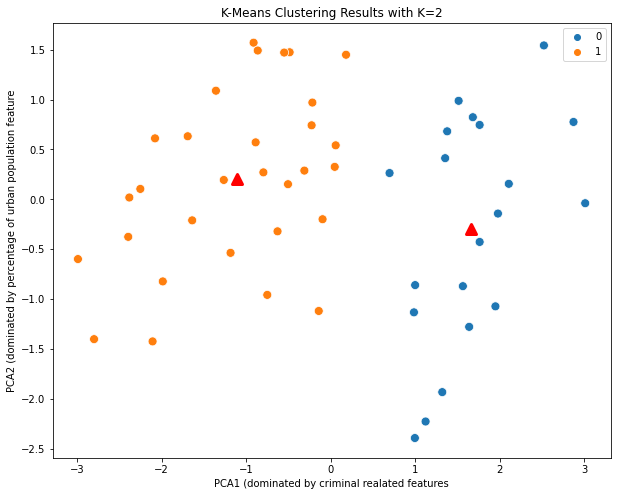

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 8]

sns.scatterplot(data=rep_mat, x=rep_mat.pca0, y=rep_mat.pca1, hue=label_pred, s=80)
plt.scatter(km2.cluster_centers_[:,0], km2.cluster_centers_[:,1], marker='^', s=100, c='red', linewidth=3)
plt.title('K-Means Clustering Results with K=2')
plt.xlabel('PCA1 (dominated by criminal realated features')
plt.ylabel('PCA2 (dominated by percentage of urban population feature')
plt.show();

In [15]:
#count the number of elements in each cluster
pd.Series(km2.labels_).value_counts()

1    30
0    20
dtype: int64

In [16]:
# Sum of distances of samples to their closest cluster center.
km2.inertia_

78.4623228750308

## Choosing K: Elbow Method

The weakness of K-means clustering is that we don’t know how many clusters we need by just running the model. We need to test possible range of values and make a decision on the best value of k. We typically make a decision using the `Elbow method` to determine the `optimal number of clusters`.

We create a for loop to calculate and save `inertia` (total within-cluster distance) values of different K-means clustering results so that we can make a decision on the best number of clusters.

In [17]:
#calculate inertia values for diffrent values of k
inertia = []
K = range(1,11)
for k in K:
    km_k = KMeans(n_clusters=k, init='random', n_init=20, random_state=1773)
    #print(k)
    km_k.fit(rep_mat)
    inertia.append(km_k.inertia_)

#inertia    

In [18]:
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer

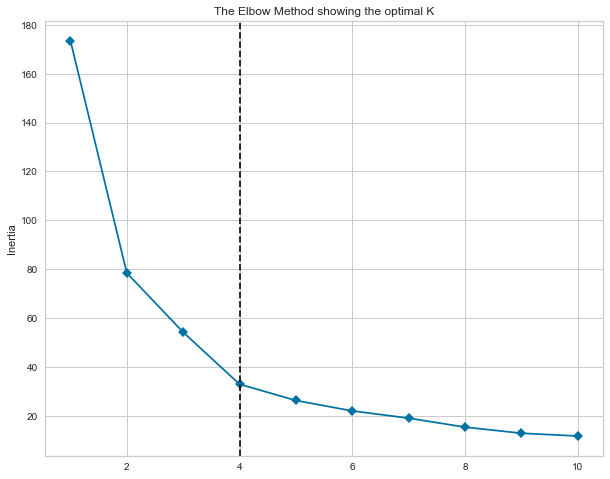

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

fig, ax = plt.subplots()

model = KMeans(n_clusters=k, init='random', n_init=20, random_state=1773)

visualizer = KElbowVisualizer(model, k=(1,11), timings=False, ax=ax)
visualizer.fit(rep_mat)        # Fit the data to the visualizer
visualizer.ax.set_ylabel('Inertia')
visualizer.ax.set_title('The Elbow Method showing the optimal K');
#visualizer.show();        

The elbow method suggests to take $K=4$ as the optimum size. We can now fit K-means with $K=4$.

In [20]:
km4 = KMeans(n_clusters=4, init='random', n_init=20, random_state=1773)
km4.fit(rep_mat)

KMeans(init='random', n_clusters=4, n_init=20, random_state=1773)

Let's get the cluster labels with `predict` method.

In [21]:
#get the cluster labels
label_pred = km4.predict(rep_mat)
label_pred

array([1, 1, 0, 1, 0, 0, 3, 3, 0, 1, 3, 2, 0, 3, 2, 3, 2, 1, 2, 0, 3, 0,
       2, 1, 3, 2, 2, 0, 2, 3, 0, 0, 1, 2, 3, 3, 3, 3, 3, 1, 2, 1, 0, 3,
       2, 3, 3, 2, 2, 3], dtype=int32)

In [22]:
#count the number of elements in each cluster
pd.Series(km4.labels_).value_counts()

3    17
2    13
0    11
1     9
dtype: int64

Let's change the cluster labels with colors so that we can see which states are clustered together.

In [23]:
#change cluster labels with colors
col = pd.Series(label_pred).replace({0:'blue',1:'green',2:'red',3:'purple'})
rep_mat_up = rep_mat.assign(color=col.values)
rep_mat_up.head()

,pca0,pca1,color
Alabama,0.985566,-1.133392,green
Alaska,1.950138,-1.073213,green
Arizona,1.763164,0.745957,blue
Arkansas,-0.141420,-1.119797,green
California,2.523980,1.542934,blue


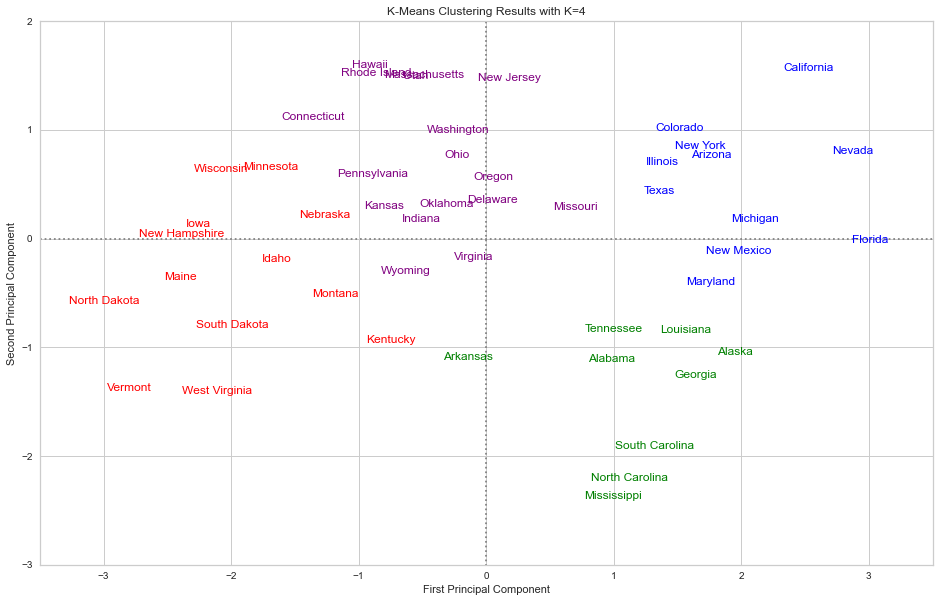

In [24]:
#illustrare states within each cluster

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

fig , ax1 = plt.subplots()

# Plot Principal Components 1 and 2
for i in rep_mat.index:
    ax1.annotate(i, (rep_mat_up.pca0.loc[i], rep_mat_up.pca1.loc[i]), ha='center', color=rep_mat_up.color.loc[i])

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.0,2)

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.title('K-Means Clustering Results with K=4')
plt.show();

We can see that there are four clusters and clusters are grouped according to their Pca1 (low, high), Pca2 level (low, high).

## Silhoutte Coefficient

### Cohesion
- `Cohesion` measures the similarity of the points in the same cluster and it can be considered as an `intra-cluster metric`.
- The `cohesion` of a data point $x_i$ is its **average distance** to all other points in 
its cluster. We can denote the `cohesion` of a data point $i$ by $a_i$ and calculate it as follows: 

$$
a_i = mean_{x_{i*} \in C }(distance(x_i, x_{i*})),
$$


- where $C$ is the cluster of $x_i$ and $x_{i*}$ is also other data point in the same cluster.

### Separation
- On the other hand, `separation` refers to the degree to which the **clusters do not overlap** and it can be considered as an `inter-cluster metric`. Intuitively, the distance between the clusters speaks about the “goodness of their separation”. So, we define the separation of a data point $x_i$ as minimum of average distance between this point and the points in another clusters.
We can denote the `separation` of a data point $x_i$ by $b_i$ and calculate it as follows: 

$$
b_i = min(mean_{x_{i*} \in C_k }(distance(x_i, x_{i*}))),
$$

- where $C_k$ is the cluster which $x_i$ **does not belong to**.

### Combining Cohesion and Separation into a Silhouette Coefficient

- The `silhoutte coefficient` of a data point $x_i$ can be calculated as follows:

$$
S_i = \frac{b_i-a_i}{max(a_i,b_i)}.
$$

- The value of $S_i$ can vary between -1 and 1. The **higher the silhouette value**, the **more certain** we can be that its label is correct. So, a high mean silhouette value of all the points indicates a good clustering.
- We want $S_i$ **to be positive** ($a_i < b_i$),
and for $a_i$ to be as close o 0 as possible, since $S_i$
assumes its maximum value of 1, when $a_i=0$.
- A **negative** $S_i$ value corresponds to a case in which $a_i$, the average
distance to points in the cluster, is greater than $b_i$, the minimum
average distance to points in another cluster.
- A **small** $S_i$ value  (around 0) means $a_i$ and $b_i$ are close to each other. This implies that the observation lies between two clusters.
- The Silhouette Coefficients of all data points can be calculated via [silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) function of scikit-learn's metrics sub-module.

## Silhouette Plots
* A `Silhouette Plot` is a graphical tool depicting how well the data points fit into the clusters they’ve been assigned to.
* In `Silhouette Plot`, the silhoutte coefficient value $S_i$ of each data point in a cluster is displayed as a horizontal line (that's the **length of the line** corresponds to silhouette coefficient) in an decreasing order.
* A `Silhouette Plot` shows the silhouettes of all the clusters in random order. Additionally, it inserts blank spaces between consecutive clusters and can color them differently.
* Data points with a **large $S_i$ (almost 1) are very well clustered**, data points with a **negative** $S_i$ are probably placed in the wrong cluster]

In [25]:
# Import SilhouetteVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [26]:
import warnings 
warnings.filterwarnings('ignore')

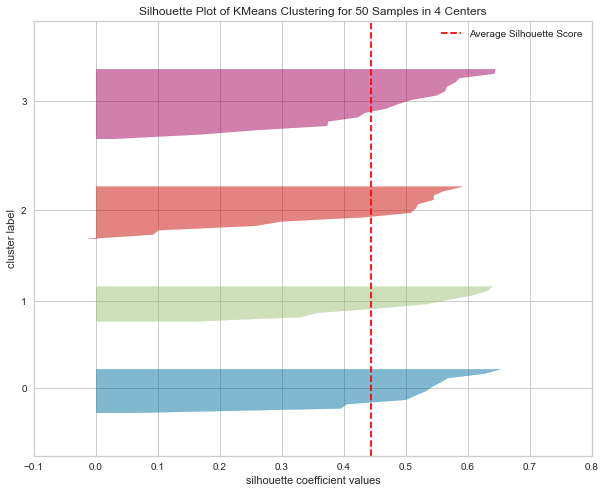

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

fig, ax = plt.subplots()

visualizer = SilhouetteVisualizer(km4, colors='yellowbrick', ax=ax)
visualizer.fit(rep_mat)  
#visualizer.ax.set_ylabel('Cluster Label')
#visualizer.ax.set_title('Silhoutte Coefficient Values');
visualizer.show();      

- Here horizontal axis shows the silhouette values, and the height of each silhouette indicates the number of points in the corresponding cluster.

- The red line shows the average silhouette value for all the clusters. In this example, the average value is 0.45.

- The separation of clusters are better when the silhouette values are close to 1. Therefore, we are looking for the clustering with a higher mean silhouette value, ideally close to 1.

In [28]:
visualizer.silhouette_samples_[0:5]

array([0.5681871 , 0.32954341, 0.65181881, 0.15352822, 0.54138985])

In [29]:
rep_mat__up = rep_mat_up.assign(Silhouette=pd.Series(visualizer.silhouette_samples_).values)
rep_mat__up[0:5]

,pca0,pca1,color,Silhouette
Alabama,0.985566,-1.133392,green,0.568187
Alaska,1.950138,-1.073213,green,0.329543
Arizona,1.763164,0.745957,blue,0.651819
Arkansas,-0.141420,-1.119797,green,0.153528
California,2.523980,1.542934,blue,0.541390


The silhouette plot shows that the data is split into four clusters of different sizes. The points in the four clusters have an average large silhouette value of 0.45.

According to Silhouette scores, Nebraska seems to be miss-clustered. Arkansas, Missouri, and Wyoming have low scores which also implies that these states can be miss-clustered as well.

## Reference

- James, G., Witten, D., Hastie, T., and Tibshirani, R. (2021). An Introduction to Statistical Learning: With Applications in R. New York: Springer.
- https://github.com/gulinan/ISLR-python/blob/master/Notebooks/Chapter%2010.ipynb
- https://franknielsen.github.io/Clustering/BookChapter-kmeans.pdf
- https://notebook.community/dapregi/toy_projects/ipython_nbs/kmeans_voronoi
- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
- https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489
- https://rstudio-pubs-static.s3.amazonaws.com/240281_216f78c66c12478b9c76e5a1e0470e60.html
- https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
- https://medium.datadriveninvestor.com/evaluation-metrics-for-clustering-96dcdbea437d
- https://www.datacamp.com/tutorial/k-means-clustering-python
- https://www.baeldung.com/cs/silhouette-values-clustering

In [30]:
import session_info
session_info.show()